### Data Wrangling with Spark

In [1]:
# import libraries 
import findspark 
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf 
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType 
from pyspark.sql.functions import desc 
from pyspark.sql.functions import asc 
from pyspark.sql.functions import sum as Fsum 



In [4]:
import datetime 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
# Create spark Session 
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

In [7]:
# spark.read.<file_format>(<path>)
path = "data/sparkify_log_small.json"
user_log = spark.read.json(path)

### Data Exploration

In [8]:
# check first 5 
# .take()
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [9]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [11]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [12]:
# describe column "artist"
user_log.describe("artist").show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [13]:
# checking columns
user_log.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [14]:
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [15]:
# check count row 
user_log.count()

10000

In [18]:
# drop duplicate and sorting by "page" column on "page" column 
# ===> check unique values on page column
# .select(<column>)  
# .dropDuplicates()
# . sort(<column>)
# . show()
user_log.select("page").dropDuplicates().sort("page").show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [20]:
# condition 
# .where(dataframe.<column> == "").collect()
user_log.select(["userId","firstname","page","song"]).where(user_log.userId =="1046").collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

### Calculating Statistics by Hour

In [21]:
# create udf 
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x /1000.0). hour)

In [28]:
# create new column
# withColumn(<new_column_name>, <target>)
user_log = user_log.withColumn("hour",get_hour(user_log.ts))

In [29]:
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='7')

In [30]:
# condition: page == "NextSong"
# => .filter(df.<column> ==  "")
# .groupby (df.<column>)
# .count()
# .orderBy(df.<column>.cast(<Type>))
songs_in_hour = user_log.filter(user_log.page == "NextSong") \
    .groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [31]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  479|
|   1|  484|
|   2|  430|
|   3|  362|
|   4|  295|
|   5|  257|
|   6|  248|
|   7|  369|
|   8|  375|
|   9|  456|
|  10|  454|
|  11|  382|
|  12|  302|
|  13|  352|
|  14|  276|
|  15|  348|
|  16|  358|
|  17|  375|
|  18|  249|
|  19|  216|
+----+-----+
only showing top 20 rows



In [32]:
# convert dataframe to pandas dataframe 
# .toPandas()
songs_in_hour_pd = songs_in_hour.toPandas()

In [33]:
songs_in_hour_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hour    24 non-null     object
 1   count   24 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 512.0+ bytes


In [34]:
# convert hour column => to type numeric 
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

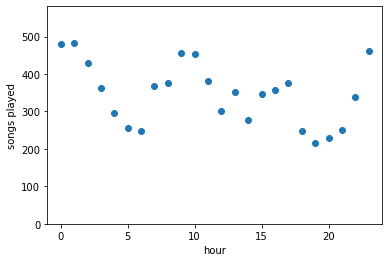

In [35]:
# visualization 
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2* max(songs_in_hour_pd['count']))
plt.xlabel("hour")
plt.ylabel("songs played");

### Drop row with Missing values

In [36]:
# drop null on userId, sessionId column 
# .dropna(how="",subset=["userId","sessionId"])
user_log_valid = user_log.dropna(how="any",subset=["userId",'sessionId'])

In [37]:
# checking count 
user_log_valid.count()

10000

In [38]:
# checking unique userId 
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [39]:
# dropping values, userId == ""
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [40]:
user_log_valid.count()

9664

### Users Downgrade their accounts 

In [41]:
# checking page column  
user_log.select("page").dropDuplicates().show()

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|            Home|
|       Downgrade|
|          Logout|
|   Save Settings|
|           About|
|        Settings|
|           Login|
|        NextSong|
|            Help|
|         Upgrade|
|           Error|
|  Submit Upgrade|
+----------------+



In [42]:
# checking "page" == Submit downgrade
user_log_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|  20|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [43]:
# checking userId == 1138
user_log.select(["userId","firstname","page","level","song"])\
    .where(user_log.userId == "1138").collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [44]:
# create function to make column to distinguish submit downgrade status 
flag_downgrade_event = udf(lambda x: 1 if x== "Submit Downgrade" else 0, IntegerType())

In [45]:
user_log_valid = user_log_valid.withColumn("downgraded",flag_downgrade_event("page"))

In [46]:
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='7', downgraded=0)

In [47]:
from pyspark.sql import Window

In [53]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [54]:
user_log_valid = user_log_valid.withColumn("phase",Fsum("downgraded").over(windowval))

In [55]:
user_log_valid.select(["userId","firstname","ts","page","level","phase"]).where(
user_log.userId == "1138").sort("ts").collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

In [59]:
user_log.select("page").dropDuplicates().where(user_log.userId == "").show()

+-----+
| page|
+-----+
|Login|
+-----+



In [60]:
user_log.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'hour']

In [62]:
# checking female user count 
user_log.select("gender").dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+



In [64]:
user_log.select("userId").dropDuplicates().where(user_log.gender == "F").count()

462

In [65]:
# how many songs were played from the most played artist?
# 1. most played artist 
# where artist == <most played artist> => select("song").dropduplicates().count()

user_log.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'hour']

In [70]:
# "artist","song"
# where or filter + groupby

user_log.select("artist").dropDuplicates().count()

3618

In [ ]:
user_log_count = user_log.withColumn

In [86]:
## 
user_log.filter(user_log.page == "NextSong") \
    .select("artist") \
    .groupBy("artist") \
    .agg({"artist":"count"}) \
    .withColumnRenamed('count(artist)','artist_count') \
    .sort(desc('artist_count')) \
    .show(1)

+--------+------------+
|  artist|artist_count|
+--------+------------+
|Coldplay|          83|
+--------+------------+
only showing top 1 row



### how many songs do user listen to on average between visiting our home page?

In [87]:
user_log.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'hour']

In [89]:
# function ishome 1 or 0 
func_ishome = udf(lambda ishome : int(ishome == "Home"), IntegerType())

In [90]:
# user window 
user_window = Window \
    .partitionBy("userID")\
    .orderBy(desc('ts'))

In [129]:
cusum = user_log.filter((user_log.page == 'NextSong') | (user_log.page == 'Home'))\
    .select("userID","page","ts") \
    .withColumn("homevisit",func_ishome(user_log.page)) \
    .withColumn("period", Fsum("homevisit").over(user_window))

In [132]:
# get avg 
cusum.filter((cusum.page == 'NextSong')) \
    .groupBy("userID","period") \
    .agg({"period":"count"}) \
    .agg({"count(period)":"avg"}).show()

+------------------+
|avg(count(period))|
+------------------+
| 6.898347107438017|
+------------------+



In [92]:
cusum.collect()

[Row(userID='', page='Home', ts=1513846494284, homevisit=1, period=1),
 Row(userID='', page='Home', ts=1513845761284, homevisit=1, period=2),
 Row(userID='', page='Home', ts=1513845132284, homevisit=1, period=3),
 Row(userID='', page='Home', ts=1513845055284, homevisit=1, period=4),
 Row(userID='', page='Home', ts=1513844251284, homevisit=1, period=5),
 Row(userID='', page='Home', ts=1513844026284, homevisit=1, period=6),
 Row(userID='', page='Home', ts=1513843602284, homevisit=1, period=7),
 Row(userID='', page='Home', ts=1513843098284, homevisit=1, period=8),
 Row(userID='', page='Home', ts=1513842367284, homevisit=1, period=9),
 Row(userID='', page='Home', ts=1513841138284, homevisit=1, period=10),
 Row(userID='', page='Home', ts=1513841121284, homevisit=1, period=11),
 Row(userID='', page='Home', ts=1513839824284, homevisit=1, period=12),
 Row(userID='', page='Home', ts=1513838865284, homevisit=1, period=13),
 Row(userID='', page='Home', ts=1513838857284, homevisit=1, period=14),
 

In [97]:
cusum.filter((cusum.page == 'NextSong')).show()

+------+----+---+---------+------+
|userID|page| ts|homevisit|period|
+------+----+---+---------+------+
+------+----+---+---------+------+

